# Fashion Forge

# 1. Setting up Environment

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf
print("Check my GPU", tf.config.list_physical_devices("GPU"))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured with memory growth")
else:
    print("No GPU detected")

GPU configured with memory growth


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# 2. Import Dataset and Check it

### This loads the fashion MNIST dataset

(X_train, y_train) (X_test, y_test)

_ discards the test dataset because we only need the training images

Values between 0 and 255 → Different shades of gray

0   → Black
127 → Medium Gray
255 → White

In [6]:
(X_train, _), (_, _) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
print("Data shape",X_train.shape)

Data shape (60000, 28, 28)


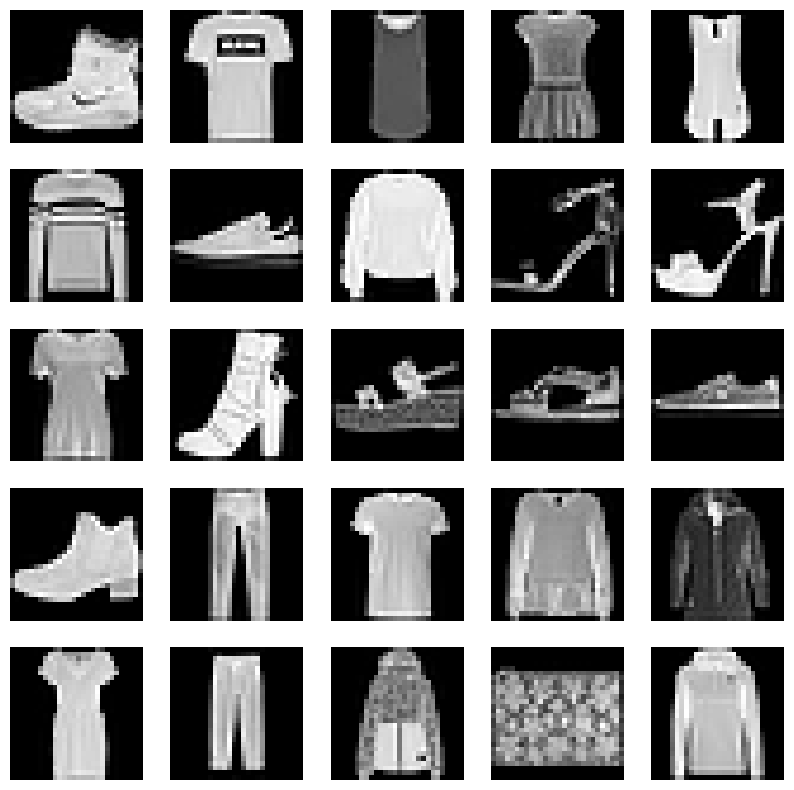

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i], cmap="gray")
  plt.axis("off")
plt.show()

# 3. Create a Data Pipeline

In [9]:
X_train.shape[0]

60000

### Normalizing the data

X_train.shape[0] → Represents the number of images (60,000 in Fashion MNIST). 28, 28 → The images are 28×28 pixels (grayscale). 1 → The extra dimension is added to indicate one color channel (grayscale).

astype("float32") -> convert them to floating point numbers, which are needed for our neural network to work efficiently

X_train = (X_train - 127.5) / 127.5

The pixex value are originally stored as integer (0-255), GANs work better in the range [-1, 1] instead of [0, 255]

In [10]:
# Normalise and reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
X_train = (X_train - 127.5) / 127.5

In [11]:
X_train.shape

(60000, 28, 28, 1)

BUFFER_SIZE = 60000:
Ensures complete shuffling of the dataset every epoch for diverse training.

BATCH_SIZE = 256:
Determines the number of images processed at once, balancing memory usage and training speed.

In [12]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [17]:
X_train

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

Before batching (60000, 28, 28, 1) -> 60,000 individual images

After batching (256, 28, 28, 1) Each batch contain 256 images

Total number of batch per epoch would be -> 60000/256 = 235

-> Coverting X_train into a Tensorflow dataset

-> Shuffles the dataset (to prevent order bias)

-> Batches the dataset into group of 256 images for efficient training

In [13]:
# Create the tensorflow dstaset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

mean=0.0 is commonly used in GANs, sometimes a small non-zero mean can improve stability.

Default → mean=0.0 (safe, but can be improved). Better choice → mean=0.01 or mean=0.02 for faster and more stable training.

Why stddev=0.02?

Based on research (from DCGAN paper), stddev=0.02 helps GANs generate sharper images. Ensures the network starts with balanced gradients.

In [14]:
LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.01, stddev=0.02)

# 4. Create a Generator and a Discriminator

In [27]:
def build_generator():
  model = keras.Sequential([
    layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)),
    layers.BatchNormalization(), # normalize the activation of the previous layer
    layers.LeakyReLU(),

    layers.Reshape((7, 7, 256)),

    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
  return model

generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# build our discriminator
def build_discriminator():
  model = keras.Sequential([
      # First COnv2d layer: Detect low level features in the images (edges, textures, ...)
      layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),

      # LeakyRelu activation function to avoid dead neurons and allow negative gradients
      layers.LeakyReLU(0.2),
      # dropout to prevent overfitting and improve generalization
      layers.Dropout(0.3),

      # First COnv2d layer: learn more complex feature from the images
      layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.3),

      # Flatten the 2D feature maps into a 1D vector for the Dense layer
      layers.Flatten(),

      layers.Dense(1, activation='sigmoid')

  ])

  return model

discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
cross_entropy = keras.losses.BinaryCrossentropy()

### Create the generator amd discriminator losses

In [18]:
# Create the discriminator loss
def discriminator_loss(real_output, fake_output):
  # calculates the loss when the discriminator classify fake images
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)

  #ccalculate the loss when the discriminator classifies fake images
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

 # Return the sum of both losses
  return real_loss + fake_loss

In [20]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)

### Building a Sub class model

In [32]:
# Building our sub ckass model
class GAN(keras.Model):
  def __init__(self, generator, discriminator):
    # initilize the GAN model  with the generator and discriminator
    super(GAN, self).__init__()
    self.generator = generator #set genrator model
    self.discriminator = discriminator # set discriminator moel


  def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
    super(GAN, self).compile()
    self.g_optimizer = g_optimizer # set the generator optimizer
    self.d_optimizer = d_optimizer # set the discriminator optimizer
    self.g_loss = g_loss # set the generator loss
    self.d_loss = d_loss # set the discriminator loss


  def train_step(self, real_images):
    # Training logic
    batch_size = tf.shape(real_images)[0]

    # Train discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as d_tape:
        generated_images = self.generator(noise)
        real_output = self.discriminator(real_images)
        fake_output = self.discriminator(generated_images)
        d_loss = self.d_loss(real_output, fake_output)

    # Cimputing the gradients for the discriminator based in its loss
    d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_images = self.generator(noise)
        fake_output = self.discriminator(generated_images)
        g_loss = self.g_loss(fake_output)

    g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_loss": g_loss}

In [41]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_images=16, latent_dim=100):
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.seed = tf.random.normal([num_images, latent_dim])

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      generated_images = self.model.generator(self.seed)
      generated_images = (generated_images * 127.5) + 127.5 #rescaleto range [0, 233]

      plt.figure(figsize=(10,10))
      for i in range(self.num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
      plt.show()

# 5. Train the Dataset

In [38]:
EPOCH = 100

In [42]:
gan = GAN(generator=generator, discriminator=discriminator)

gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - d_loss: 1.3343 - g_loss: 0.7592

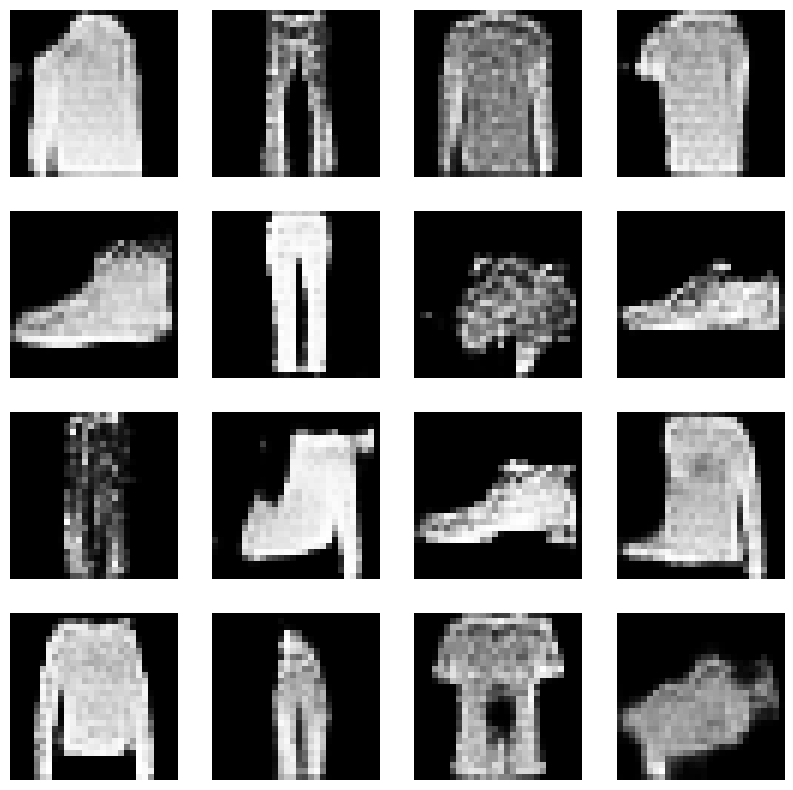

235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - d_loss: 1.3343 - g_loss: 0.7595
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3422 - g_loss: 0.7676
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3441 - g_loss: 0.7722
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3362 - g_loss: 0.7636
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3374 - g_loss: 0.7638
Epoch 6/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3357 - g_loss: 0.7660

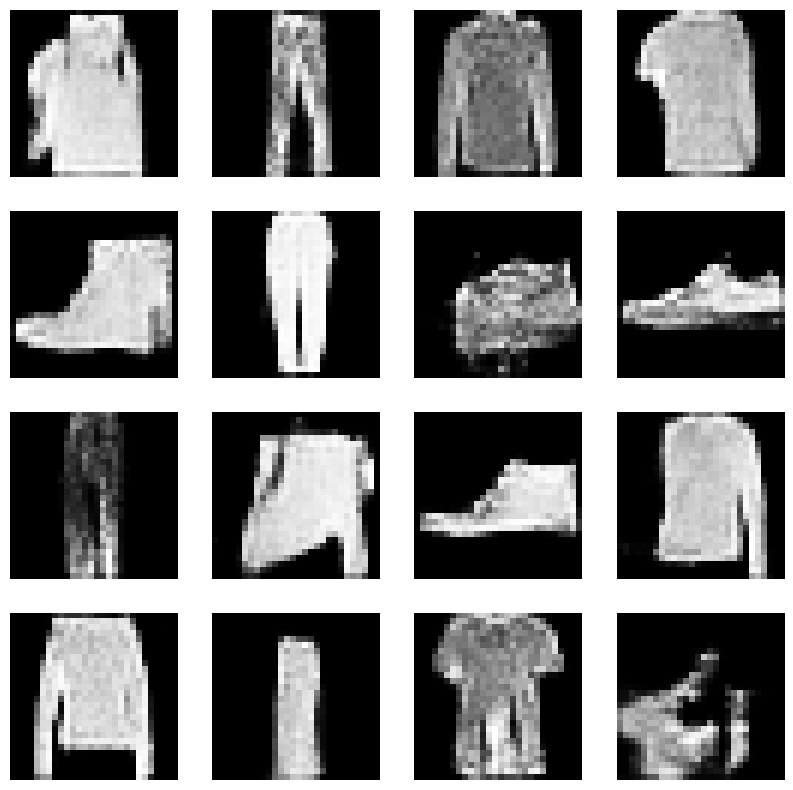

235/235 ━━━━━━━━━━━━━━━━━━━━ 75s 294ms/step - d_loss: 1.3356 - g_loss: 0.7654
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3369 - g_loss: 0.7721
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3368 - g_loss: 0.7660
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3356 - g_loss: 0.7631
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3365 - g_loss: 0.7689
Epoch 11/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 1.3350 - g_loss: 0.7608

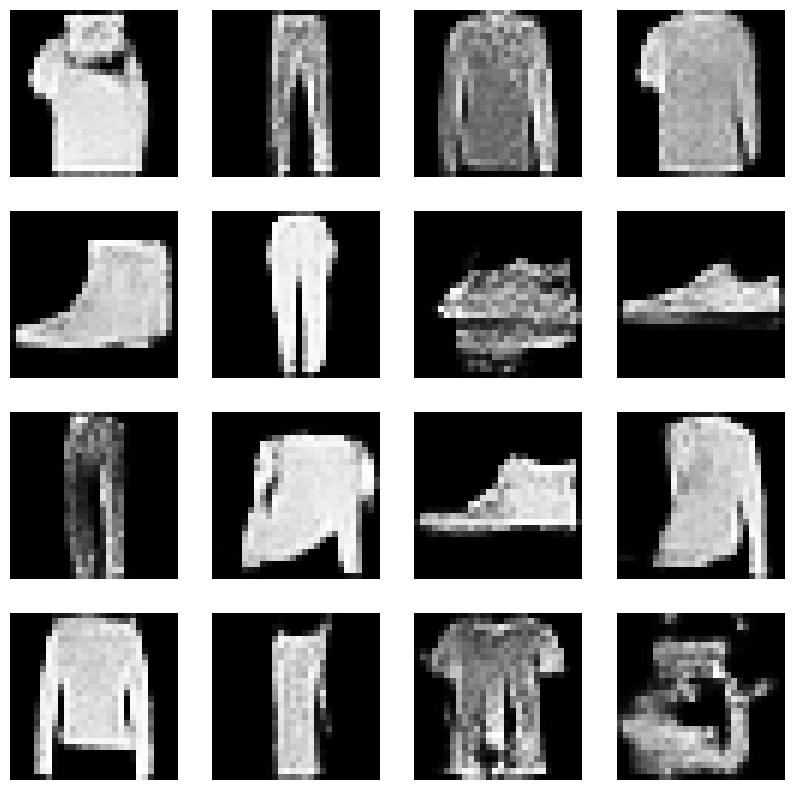

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3352 - g_loss: 0.7620
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3366 - g_loss: 0.7664
Epoch 13/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3369 - g_loss: 0.7730
Epoch 14/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3329 - g_loss: 0.7698
Epoch 15/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - d_loss: 1.3334 - g_loss: 0.7677
Epoch 16/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3347 - g_loss: 0.7672

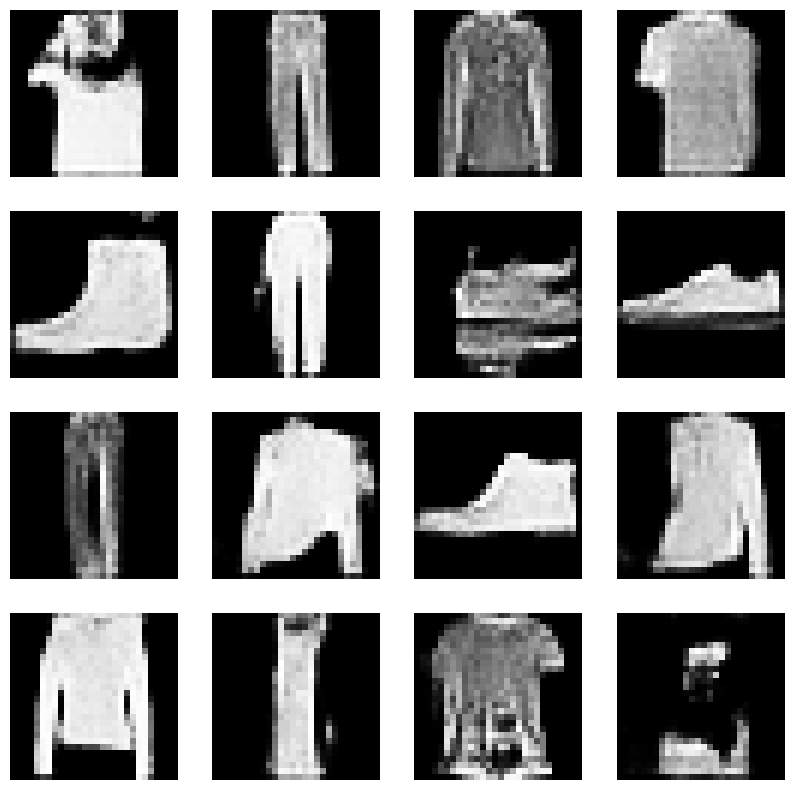

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3347 - g_loss: 0.7679
Epoch 17/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3343 - g_loss: 0.7696
Epoch 18/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3315 - g_loss: 0.7658
Epoch 19/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3351 - g_loss: 0.7690
Epoch 20/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3327 - g_loss: 0.7652
Epoch 21/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3370 - g_loss: 0.7707

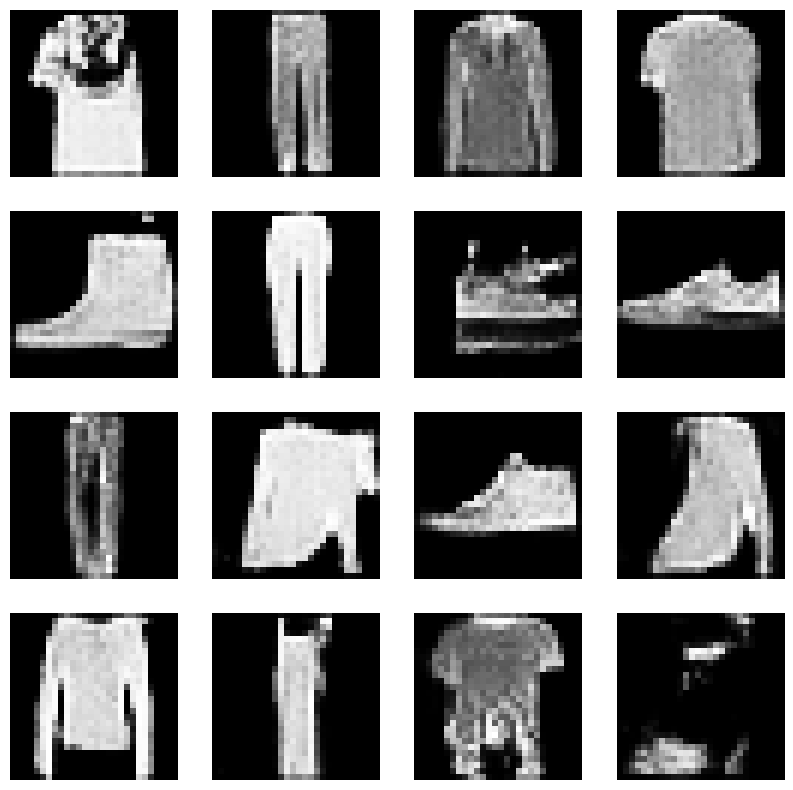

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3370 - g_loss: 0.7710
Epoch 22/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3342 - g_loss: 0.7654
Epoch 23/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3342 - g_loss: 0.7678
Epoch 24/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3340 - g_loss: 0.7631
Epoch 25/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3342 - g_loss: 0.7698
Epoch 26/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3319 - g_loss: 0.7798

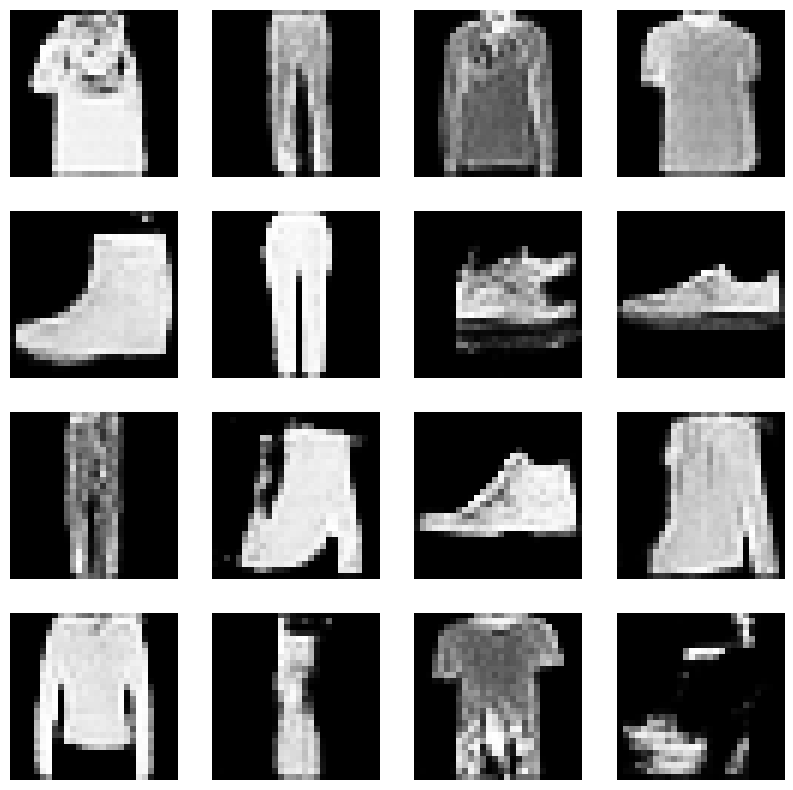

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3320 - g_loss: 0.7792
Epoch 27/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3360 - g_loss: 0.7709
Epoch 28/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3322 - g_loss: 0.7700
Epoch 29/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3319 - g_loss: 0.7700
Epoch 30/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3327 - g_loss: 0.7670
Epoch 31/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3323 - g_loss: 0.7694

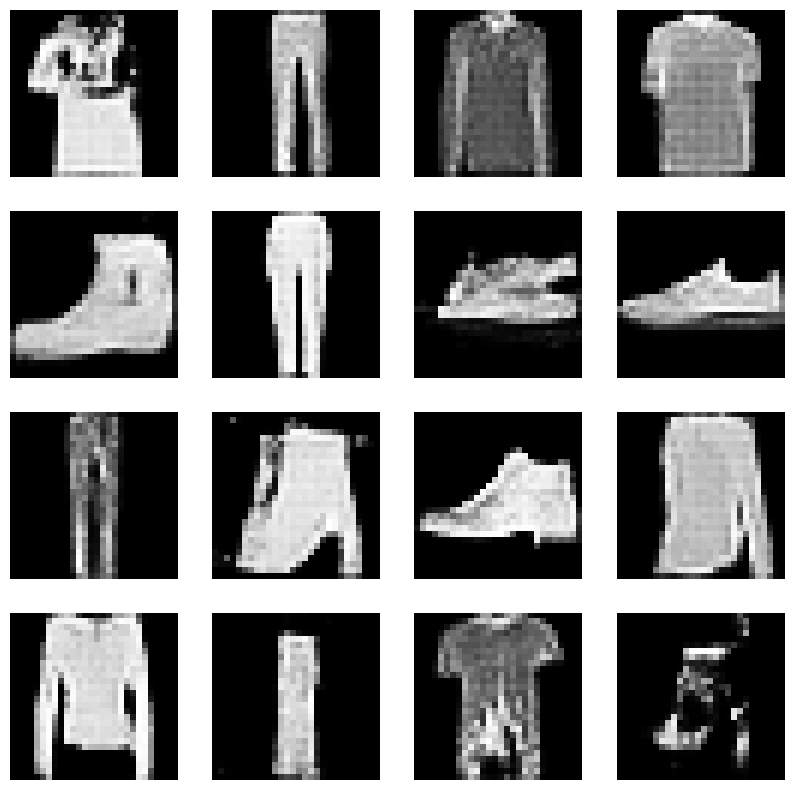

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3321 - g_loss: 0.7699
Epoch 32/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3323 - g_loss: 0.7696
Epoch 33/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3345 - g_loss: 0.7742
Epoch 34/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3310 - g_loss: 0.7696
Epoch 35/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3312 - g_loss: 0.7734
Epoch 36/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3295 - g_loss: 0.7725

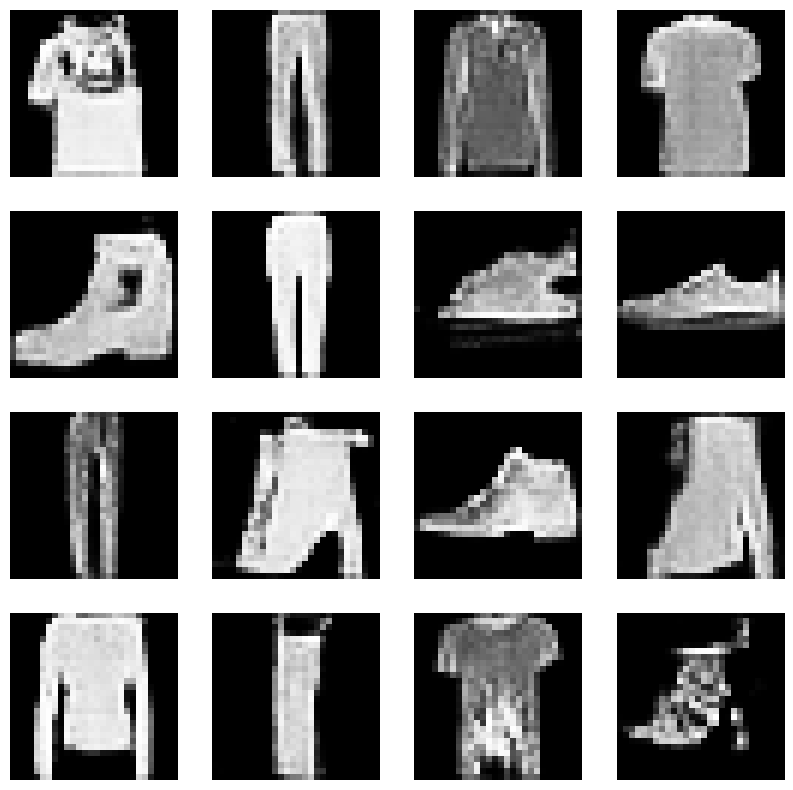

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3295 - g_loss: 0.7719
Epoch 37/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3272 - g_loss: 0.7742
Epoch 38/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3293 - g_loss: 0.7735
Epoch 39/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3260 - g_loss: 0.7719
Epoch 40/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3268 - g_loss: 0.7715
Epoch 41/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3251 - g_loss: 0.7709

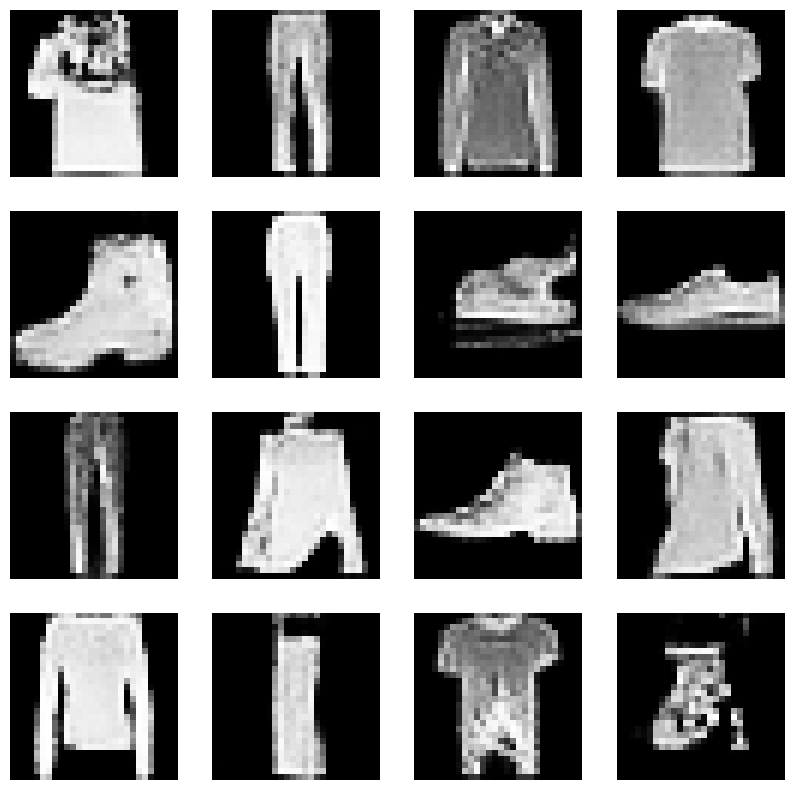

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - d_loss: 1.3253 - g_loss: 0.7717
Epoch 42/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3265 - g_loss: 0.7741
Epoch 43/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3282 - g_loss: 0.7758
Epoch 44/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3257 - g_loss: 0.7771
Epoch 45/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3294 - g_loss: 0.7768
Epoch 46/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3251 - g_loss: 0.7749

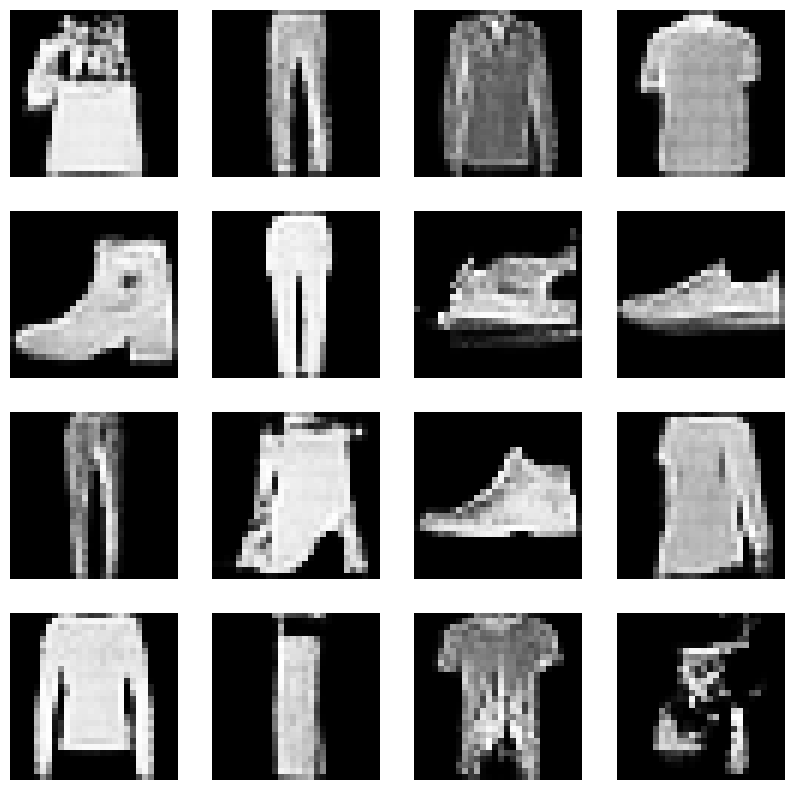

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3248 - g_loss: 0.7745
Epoch 47/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3240 - g_loss: 0.7764
Epoch 48/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3220 - g_loss: 0.7771
Epoch 49/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - d_loss: 1.3240 - g_loss: 0.7800
Epoch 50/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - d_loss: 1.3240 - g_loss: 0.7803
Epoch 51/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3218 - g_loss: 0.7810

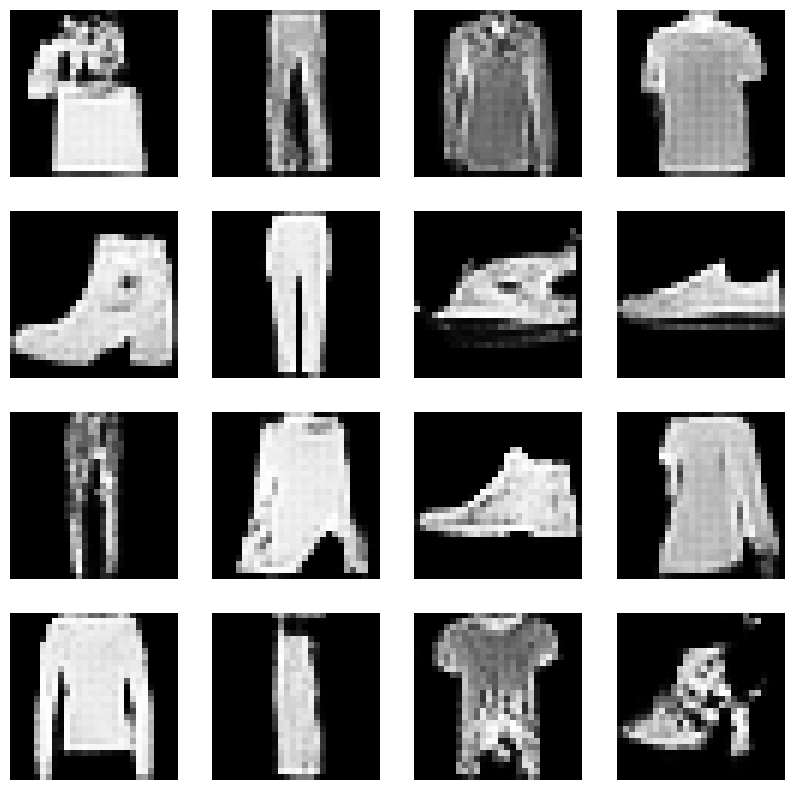

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3217 - g_loss: 0.7802
Epoch 52/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - d_loss: 1.3216 - g_loss: 0.7763
Epoch 53/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3219 - g_loss: 0.7813
Epoch 54/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3192 - g_loss: 0.7790
Epoch 55/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3204 - g_loss: 0.7787
Epoch 56/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3185 - g_loss: 0.7809

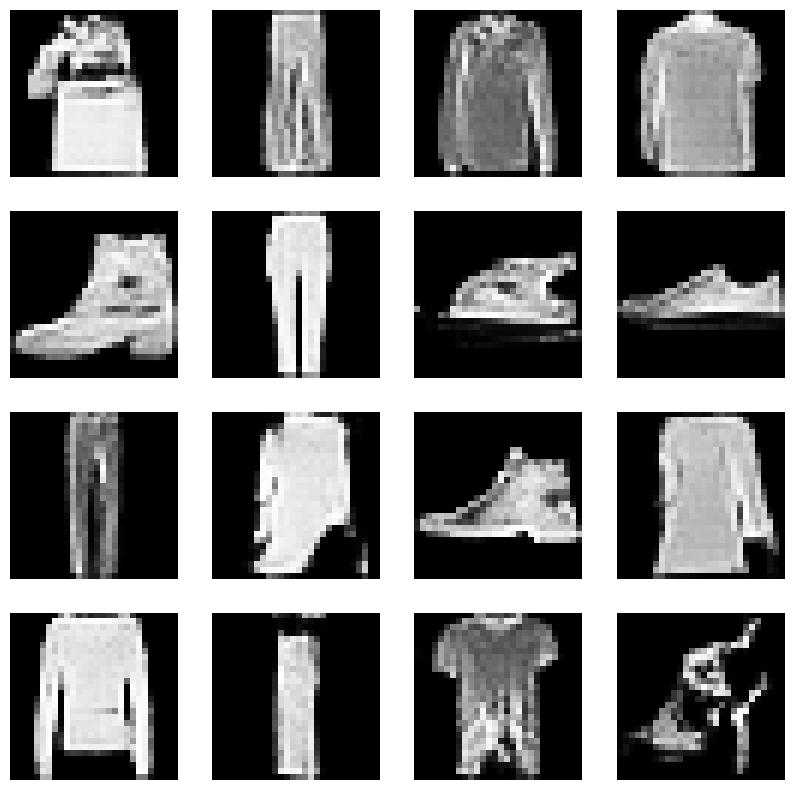

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3190 - g_loss: 0.7814
Epoch 57/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3195 - g_loss: 0.7828
Epoch 58/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3193 - g_loss: 0.7841
Epoch 59/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3202 - g_loss: 0.7845
Epoch 60/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3186 - g_loss: 0.7817
Epoch 61/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3173 - g_loss: 0.7843

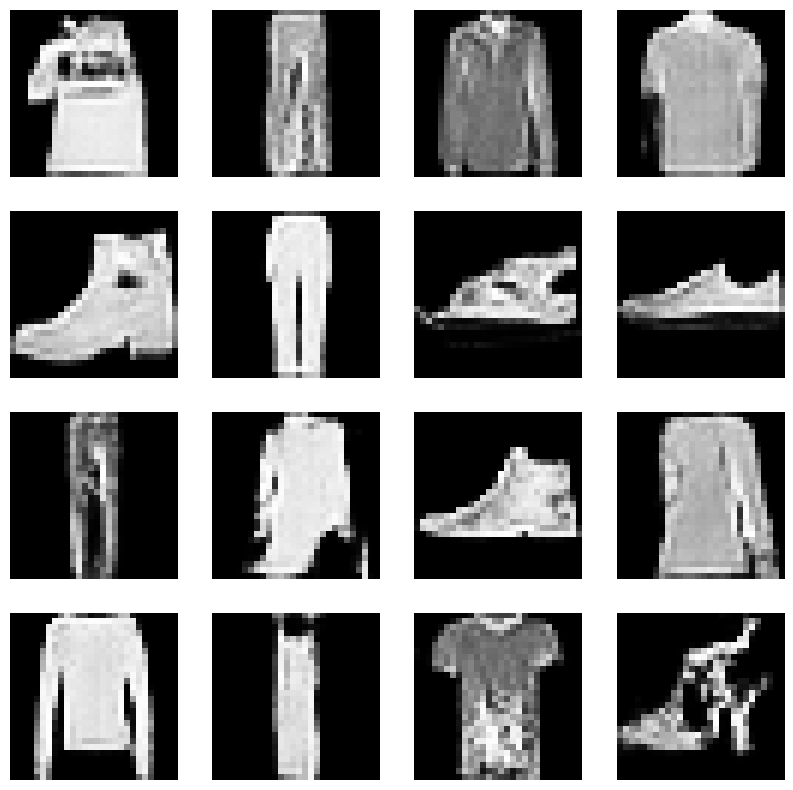

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3177 - g_loss: 0.7855
Epoch 62/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3161 - g_loss: 0.7864
Epoch 63/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3181 - g_loss: 0.7863
Epoch 64/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3150 - g_loss: 0.7835
Epoch 65/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3125 - g_loss: 0.7879
Epoch 66/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3165 - g_loss: 0.7857

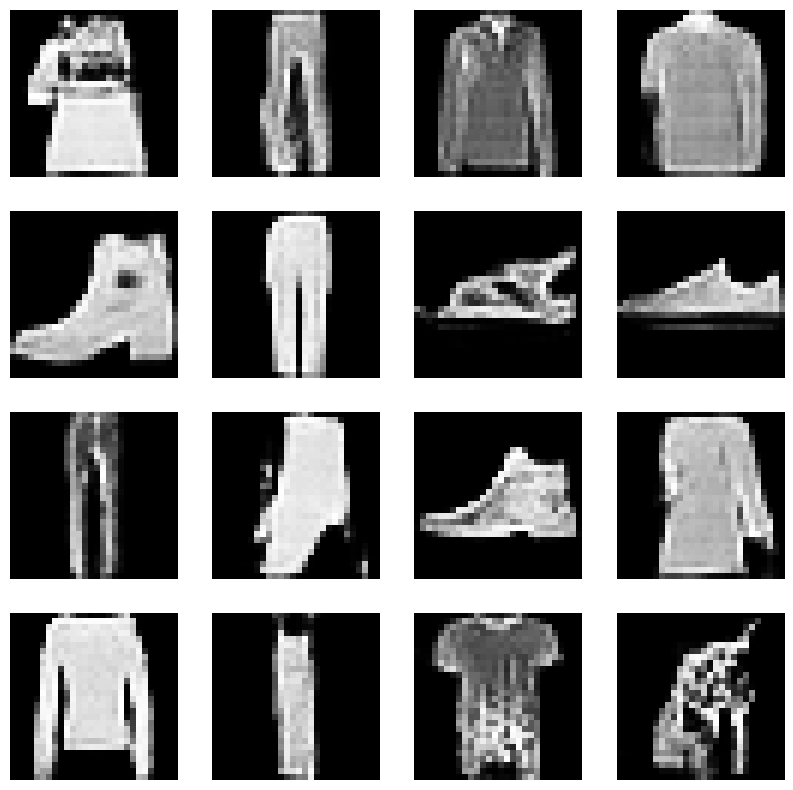

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3161 - g_loss: 0.7856
Epoch 67/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3163 - g_loss: 0.7874
Epoch 68/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3129 - g_loss: 0.7888
Epoch 69/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3128 - g_loss: 0.7884
Epoch 70/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3134 - g_loss: 0.7910
Epoch 71/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3127 - g_loss: 0.7917

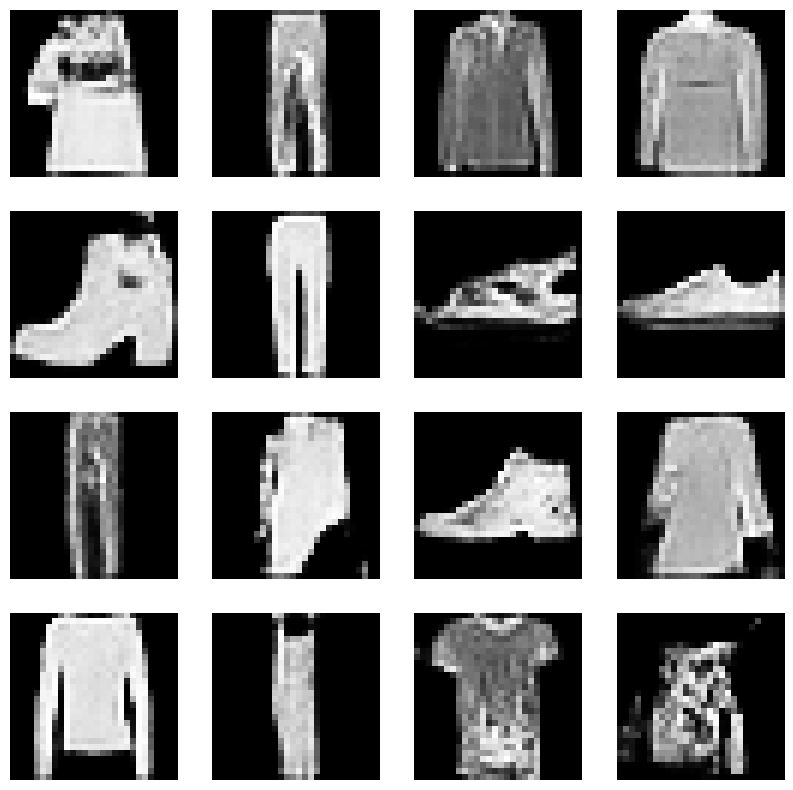

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3123 - g_loss: 0.7928
Epoch 72/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3097 - g_loss: 0.7912
Epoch 73/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3130 - g_loss: 0.7926
Epoch 74/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3146 - g_loss: 0.7924
Epoch 75/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3107 - g_loss: 0.7891
Epoch 76/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3118 - g_loss: 0.7911

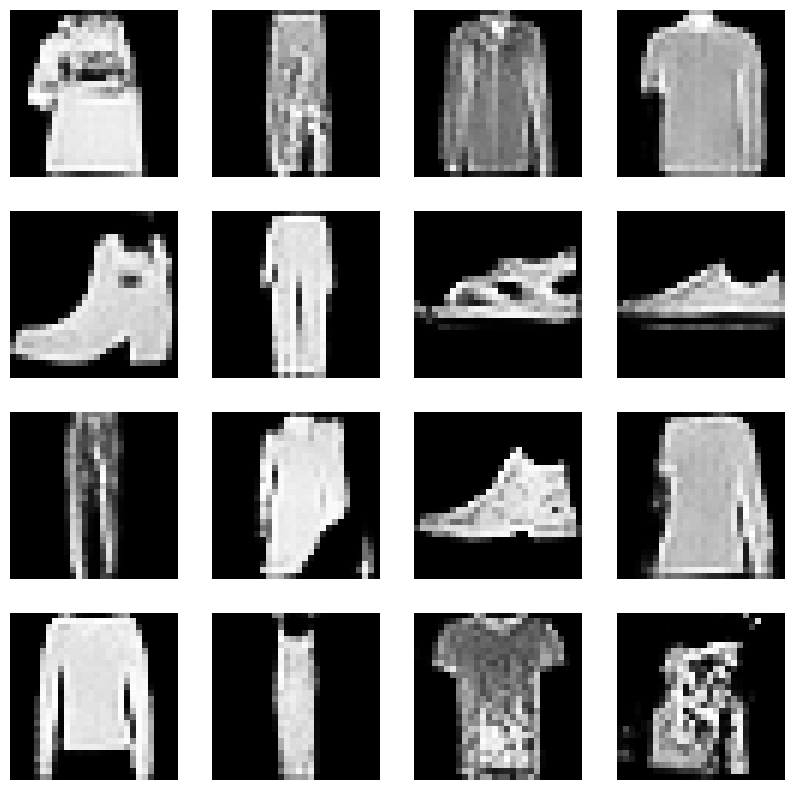

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3114 - g_loss: 0.7914
Epoch 77/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3106 - g_loss: 0.7912
Epoch 78/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3088 - g_loss: 0.7950
Epoch 79/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - d_loss: 1.3095 - g_loss: 0.7947
Epoch 80/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3100 - g_loss: 0.7980
Epoch 81/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3067 - g_loss: 0.7959

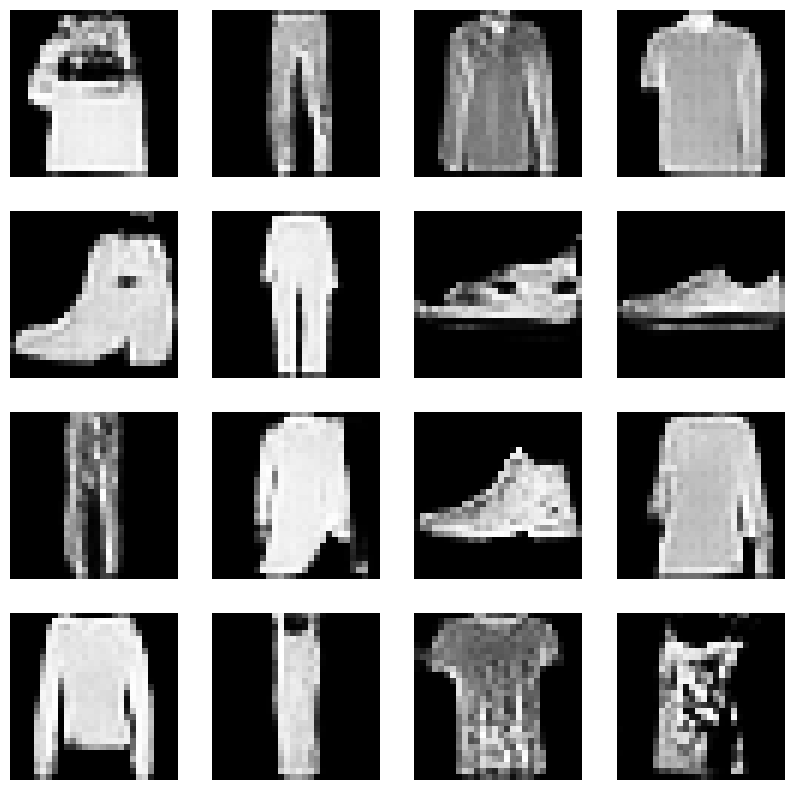

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - d_loss: 1.3069 - g_loss: 0.7972
Epoch 82/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3056 - g_loss: 0.7976
Epoch 83/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3085 - g_loss: 0.7978
Epoch 84/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3061 - g_loss: 0.7968
Epoch 85/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3073 - g_loss: 0.8002
Epoch 86/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3043 - g_loss: 0.7979

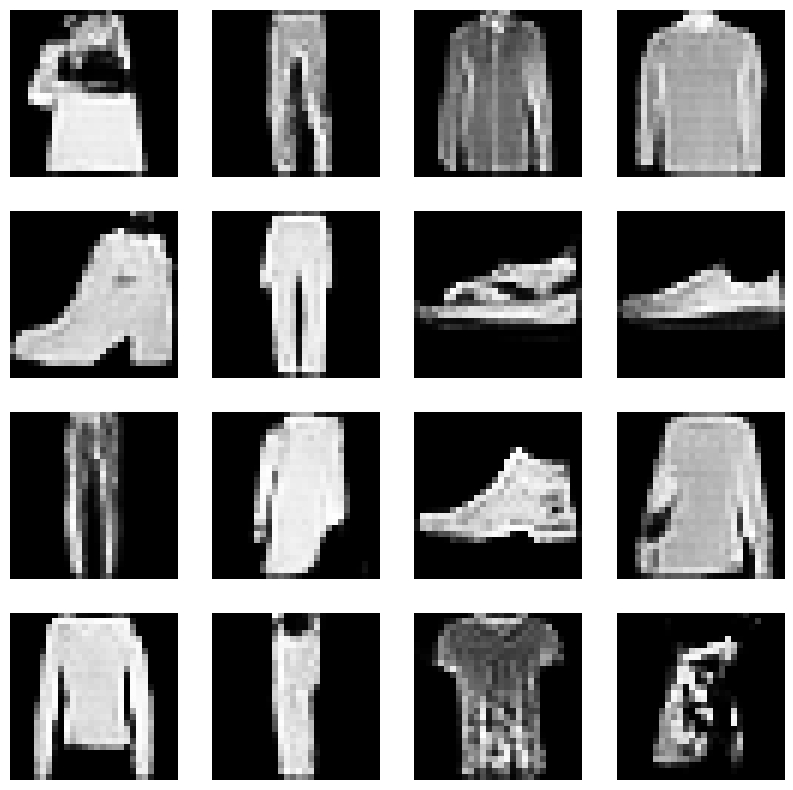

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3043 - g_loss: 0.7972
Epoch 87/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3037 - g_loss: 0.8021
Epoch 88/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3061 - g_loss: 0.8015
Epoch 89/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3072 - g_loss: 0.7972
Epoch 90/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3073 - g_loss: 0.8029
Epoch 91/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3039 - g_loss: 0.7991

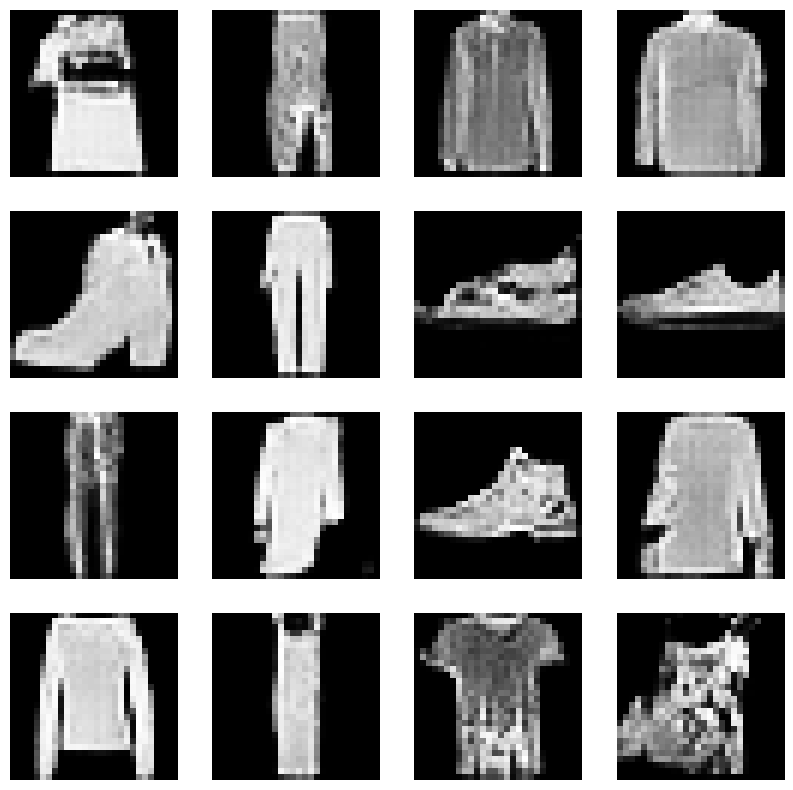

235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - d_loss: 1.3041 - g_loss: 0.7974
Epoch 92/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3064 - g_loss: 0.8035
Epoch 93/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - d_loss: 1.3023 - g_loss: 0.8041
Epoch 94/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - d_loss: 1.3025 - g_loss: 0.7971
Epoch 95/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3040 - g_loss: 0.7999
Epoch 96/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 1.3048 - g_loss: 0.8015

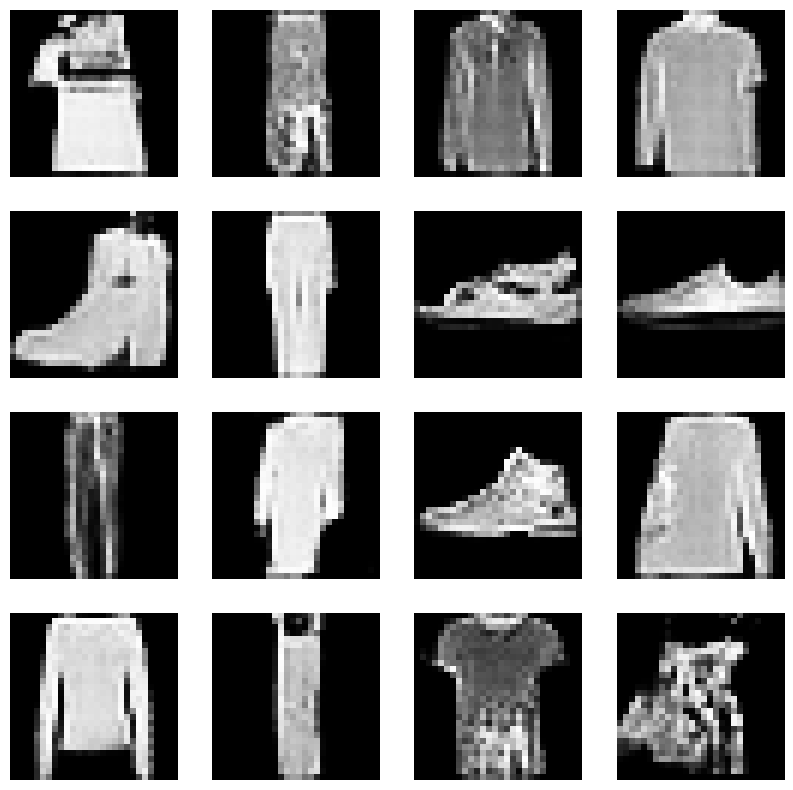

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - d_loss: 1.3049 - g_loss: 0.8014
Epoch 97/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3037 - g_loss: 0.7987
Epoch 98/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3046 - g_loss: 0.8041
Epoch 99/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - d_loss: 1.3025 - g_loss: 0.8063
Epoch 100/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - d_loss: 1.3021 - g_loss: 0.8038


In [43]:
history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[ImageCallback()])

# 6. Evaluate the model and save it